# TP3 - Grupo 20
###  Dezembro, 4, 2024

Afonso Martins Campos Fernandes - A102940

Luís Filipe Pinheiro Silva - A105530

## Problema 2

#### a) Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos.

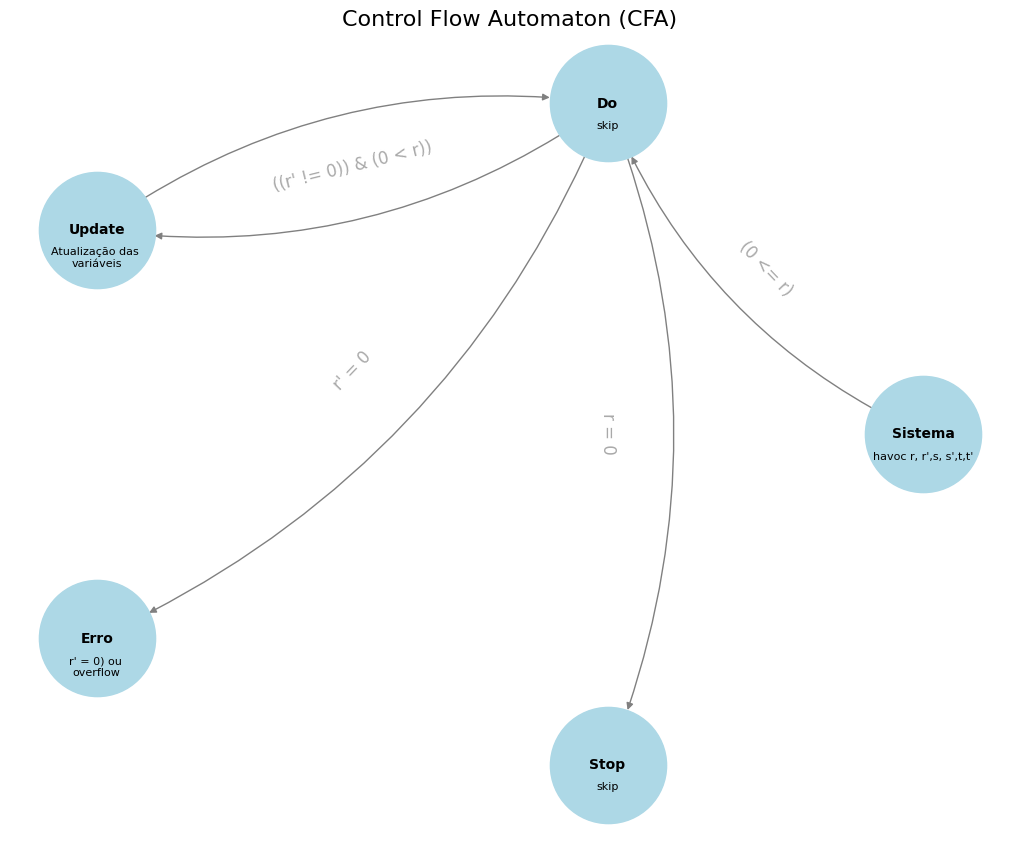

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

# Criação do grafo usando NetworkX
G = nx.DiGraph()

# Adicionando nós
G.add_node('Sistema', annotation="havoc r, r',s, s',t,t'")
G.add_node('Do', annotation='skip')
G.add_node('Update', annotation='Atualização das \nvariáveis')
G.add_node('Erro', annotation='r\' = 0) ou \noverflow')
G.add_node('Stop', annotation='skip')

# Adicionando arestas (transições)
G.add_edge('Sistema', 'Do', label='(0 <= r)')
G.add_edge('Do', 'Update', label='((!(r\' = 0)) & (0 < r))')
G.add_edge('Do', 'Erro', label='r\' = 0')
G.add_edge('Update', 'Do', label='((r\' != 0)) & (0 < r))')
G.add_edge('Do', 'Stop', label='r = 0')

# Posicionamento dos nós (usando um layout circular para clareza)
pos = nx.circular_layout(G)

# Desenhando o grafo sem labels externos
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray',connectionstyle="arc3,rad=-0.2")



# Adicionando rótulos nas arestas
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_weight='normal', font_color='darkgray')

annotations = nx.get_node_attributes(G, 'annotation')
for node, annotation in annotations.items():
    xp, yp = pos[node]
    plt.text(xp, yp-0.05, annotation, fontsize=8, ha='center', va='top')


# Exibindo o diagrama
plt.title('Control Flow Automaton (CFA)', fontsize=16)
plt.axis('off')  # Desativa o eixo para uma melhor visualização
plt.show()


#### b) Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema. Sugere-se (não é obrigatório mas é valorizado !), na alínea (a), uma representação do CFA através de  um grafo orientado  implementado  em `networkx`  e a sua compilação para o sistema de equações.

In [4]:
from z3 import *
import networkx as nx

def graph_safety_z3(G, n):
    print(f"> A testar {n} iterações.")
    
    # Define variáveis simbólicas
    r, r_prime = Ints("r r_prime")
    s, s_prime = Ints("s s_prime")
    t, t_prime = Ints("t t_prime")
    q = Int("q")
    
    do = BoolVal(False)  # Representa o estado atual do sistema (inicialmente seguro)
    
    # Extrai a condição de guarda do grafo
    guarda = BoolVal(False)
    for source, target, data in G.edges(data=True):
        if source == "system" and target == "do":
            guarda = Or(guarda, data["condition"])  # Combina as condições de guarda com OR
    
    # Criar um solver Z3
    solver = Solver()
    
    # Iteração para verificar a segurança do sistema
    for i in range(n):
        system = And(guarda, do)  # Estado do sistema baseado na guarda e no estado 'do'
        
        # Verificar se o sistema é inseguro nesta iteração
        solver.push()
        solver.add(system)
        if solver.check() == sat:
            print(f"> Iteração {i}: sistema inseguro.")
            return
        solver.pop()
        # requesitos guardados numa lista para dar check se está tudo como é suposto
        req = []
        for source, target, data in G.edges(data=True):
            condition = data["condition"]
            if source == "do":
                if target == "error":
                    req.append(Implies(condition, True))  # Insegurança leva ao estado final
                elif target == "stop":
                    req.append(Implies(condition, False))  # Parada interrompe a propagação
                elif target == "update":
                    # Substituições para a atualização
                    new_do = And(
                        r_prime == r - q * r_prime,
                        s_prime == s - q * s_prime,
                        t_prime == t - q * t_prime,
                    )
                    req.append(Implies(condition, new_do))
                else:
                    req.append(Implies(condition, do))
        
        # Determinar o novo estado do sistema
        new_do = And(req)
        
        # Verificar se o estado estabilizou
        solver.push()
        solver.add(do != new_do)
        if solver.check() == unsat:  # Se `do == new_do`, significa que estabilizou
            print(f"> Iteração {i}: sistema seguro.")
            return
        solver.pop()
        
        # Atualizar o estado para a próxima iteração
        do = Or(do, new_do)
    
    print("> Não foram encontrados estados inseguros.")

# Criar um grafo de teste
G = nx.DiGraph()
G.add_edge("system", "do", condition=BoolVal(True))
G.add_edge("do", "error", condition=Int("r_prime") == 0)
G.add_edge("do", "stop", condition=Int("r") == 0)
G.add_edge("do", "update", condition=Int("r") > 0)

# Executar a função
graph_safety_z3(G, 10)


> A testar 10 iterações.
> Iteração 1: sistema inseguro.
